In [10]:
import numpy as np
import pandas as pd
from joblib import dump, load
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import itertools
import os

In [2]:
# SINGLE or TWIN
which_data = "SINGLE"

# Specify the directory path
dir_path = "../files/data/FINAL_CSV/{}/TEST".format(which_data)

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

csv_files

['CORNER_CRACK_CS3_QUARTER_ELLIPSE_TEST.csv',
 'CORNER_CRACK_CS2_THROUGH_CS_THICKNESS_TEST.csv',
 'CORNER_CRACK_BH_THROUGH_THICKNESS_TEST.csv',
 'CORNER_CRACK_CS2_QUARTER_ELLIPSE_TEST.csv',
 'CORNER_CRACK_CS4_QUARTER_ELLIPSE_TEST.csv',
 'CORNER_CRACK_BH_QUARTER_ELLIPSE_TEST.csv',
 'SURFACE_CRACK_TEST.csv',
 'CORNER_CRACK_CS4_THROUGH_CS_THICKNESS_TEST.csv',
 'CORNER_CRACK_CS1_QUARTER_ELLIPSE_TEST.csv']

# L2 Table

In [26]:
def display_numpy_array_as_table(arr):
    """
    Displays a 2D NumPy array as a formatted table.

    Args:
        arr (np.ndarray): The 2D NumPy array to display.
    """
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        print("Input must be a 2D NumPy array.")
        return

    # Determine the maximum width needed for each column
    # Convert all elements to strings first to handle different data types
    arr_str = np.array([[str(item) for item in row] for row in arr])
    col_widths = [max(len(item) for item in arr_str[:, col_idx]) for col_idx in range(arr_str.shape[1])]

    # Print the table header (optional, but good for clarity)
    # print(" | ".join(f"{'Col ' + str(i):<{col_widths[i]}}" for i in range(arr.shape[1])))
    # print("-+-".join("-" * width for width in col_widths)) # Separator line

    # Print the data rows
    for row in arr_str:
        print(" | ".join(f"{item:<{col_widths[i]}}" for i, item in enumerate(row)))


rfr_l2_test = np.load("../files/metrics/l2_err_rfr.npy")

svr_l2_test = np.load("../files/metrics/l2_err_svr.npy")

nn_l2_test = np.load("../files/metrics/l2_err_nn.npy")

fno_l2_test = np.load("../files/metrics/l2_err_fno.npy")

for (i, csv_file) in enumerate(csv_files):
    print("===============================================")
    print(csv_file)
    print("===============================================")
    print("RFR: ", end="")
    display_numpy_array_as_table(np.expand_dims(rfr_l2_test[i], axis=0))
    print("SVR: ", end="")
    display_numpy_array_as_table(np.expand_dims(svr_l2_test[i], axis=0))
    print("NN: ", end="")
    display_numpy_array_as_table(np.expand_dims(nn_l2_test[i], axis=0))
    print("FNO: ", end="")
    display_numpy_array_as_table(np.expand_dims(fno_l2_test[i], axis=0))

CORNER_CRACK_CS3_QUARTER_ELLIPSE_TEST.csv
RFR: 0.03375235708812186 | 0.032835056915870145 | 0.043110955148459536
SVR: 0.31982003196240966 | 0.31754204134168956 | 0.3283491865708158
NN: 0.034088782299323654 | 0.047883118863413475 | 0.03951384582548586
FNO: 0.27906343895242885 | 0.25161267161277223 | 0.2859184563273222
CORNER_CRACK_CS2_THROUGH_CS_THICKNESS_TEST.csv
RFR: 0.12353802610269535 | 0.20928984300885597 | 0.23856922333343725
SVR: 0.1874345289024565 | 0.5993631571134995 | 0.22450747673171376
NN: 0.21870644904980005 | 0.5336553278788634 | 0.33167438258431153
FNO: 0.12462306676819652 | 0.17716344158605954 | 0.15165577425104268
CORNER_CRACK_BH_THROUGH_THICKNESS_TEST.csv
RFR: 0.03203494754662809 | 0.042661505215042896 | 0.08395633934666162
SVR: 0.1899404789000461 | 0.9600174414128466 | 0.7282339780828072
NN: 0.027698432698542573 | 0.11529717222737029 | 0.12335271271489907
FNO: 0.2017669558733479 | 0.1721623910321275 | 0.5205414570506076
CORNER_CRACK_CS2_QUARTER_ELLIPSE_TEST.csv
RFR: 0

# CORNER_CRACK_CS3_QUARTER_ELLIPSE

In [3]:
df = pd.read_csv("../files/data/FINAL_CSV/SINGLE/TEST/{}".format(csv_files[0]))
df = df.drop(columns=['b/t'])
df

,c_index,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,0.0,2.4,0.1,0.01,0.750,0.057972,0.429995,0.724687,0.201466
1,0.0,2.4,0.1,0.01,0.750,0.069428,0.437857,0.737504,0.205187
2,0.0,2.4,0.1,0.01,0.750,0.080884,0.447299,0.752671,0.209626
3,0.0,2.4,0.1,0.01,0.750,0.092340,0.457868,0.769862,0.214558
4,0.0,2.4,0.1,0.01,0.750,0.103796,0.469303,0.788463,0.219925
...,...,...,...,...,...,...,...,...,...
2731515,85359.0,40.0,10.0,0.10,1.333,1.467062,0.678134,0.348650,0.173734
2731516,85359.0,40.0,10.0,0.10,1.333,1.478518,0.662603,0.340562,0.169772
2731517,85359.0,40.0,10.0,0.10,1.333,1.489974,0.648277,0.333106,0.166112
2731518,85359.0,40.0,10.0,0.10,1.333,1.501431,0.635496,0.326390,0.162800


In [4]:
# Get unique combinations of the first four columns
test_combinations = df.iloc[:, 1:5].drop_duplicates().to_numpy()

print(len(test_combinations))

print("Different W/R values: ", np.unique(test_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(test_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(test_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(test_combinations[:,3], axis=0))

21340
Different W/R values:  [  1.6   1.8   2.    2.2   2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2
   5.8   6.4   7.    8.    9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
Different r/t values:  [ 0.1     0.111   0.125   0.25    0.333   0.4     0.5714  0.667   0.75
  0.8     1.      1.25    1.333   1.5     2.      2.25    2.5     3.
  4.      5.      7.      9.     10.    ]


## Preds

In [5]:
y_pred_t_rfr = np.load("../files/predictions/rfr/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_rfr = np.load("../files/predictions/rfr/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_rfr = np.load("../files/predictions/rfr/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_svr = np.load("../files/predictions/svr/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_svr = np.load("../files/predictions/svr/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_svr = np.load("../files/predictions/svr/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_nn = np.load("../files/predictions/nn/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_nn = np.load("../files/predictions/nn/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_nn = np.load("../files/predictions/nn/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_fno = np.load("../files/predictions/fno/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_fno = np.load("../files/predictions/fno/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_fno = np.load("../files/predictions/fno/{}_BEARING.npy".format(csv_files[0][:-4]))

## Plots

In [7]:
def absolute_perctentage_error(y_true, y_pred):
    return np.abs((y_true -  y_pred) / y_true)

def perctentage_error(y_true, y_pred):
    return (y_true -  y_pred) / y_true

def mean_normalized_l2(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true -  y_pred, ord=2, axis=1) / np.linalg.norm(y_true, ord=2, axis=1))

In [8]:
d = df.to_numpy()[::8,1:]
d.shape

(341440, 8)

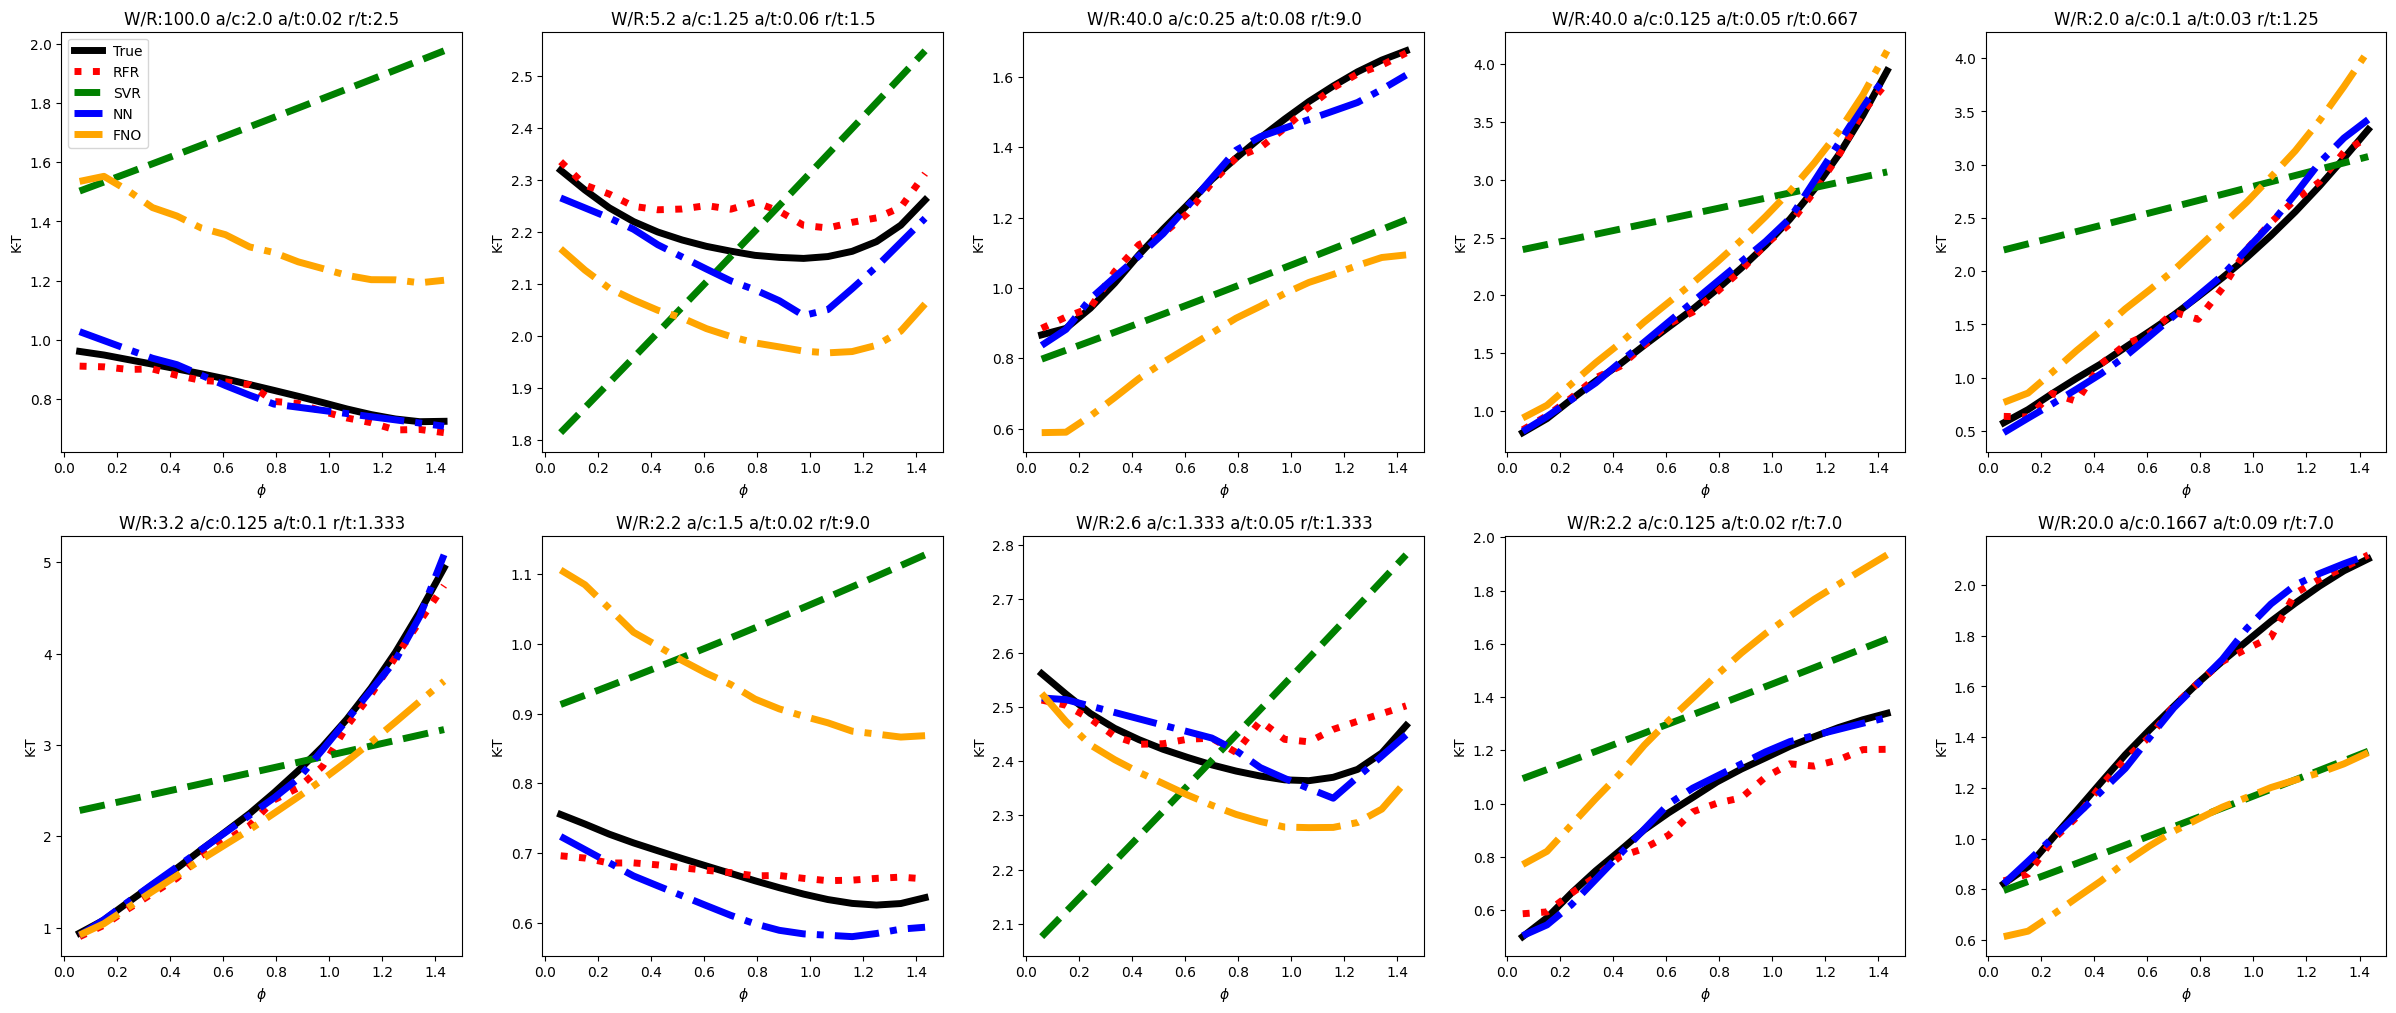

In [ ]:

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_combinations))
        W_R = test_combinations[idx][0]
        a_c = test_combinations[idx][1]
        a_t = test_combinations[idx][2]
        r_t = test_combinations[idx][3]

        indices = np.where((d[:, 0] == W_R) & 
                    (d[:, 1] == a_c) &
                    (d[:, 2] == a_t) &
                    (d[:, 3] == r_t)) 
        indices = indices[0]

        phi_values = d[indices][:,4]

        axs[i,j].plot(d[indices][:,-4], d[indices][:,-3], color='black', label="True", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_rfr[idx*16:idx*16+16], label="RFR", color='red', linestyle=":", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_svr[idx*16:idx*16+16], label="SVR", color='green', linestyle="--", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_nn[idx*16:idx*16+16], label="NN", color='blue', linestyle="-.", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_fno[idx,::8], label="FNO", color='orange', linestyle="dashdot", linewidth=5)
        

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{}".format(W_R, a_c, a_t, r_t))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

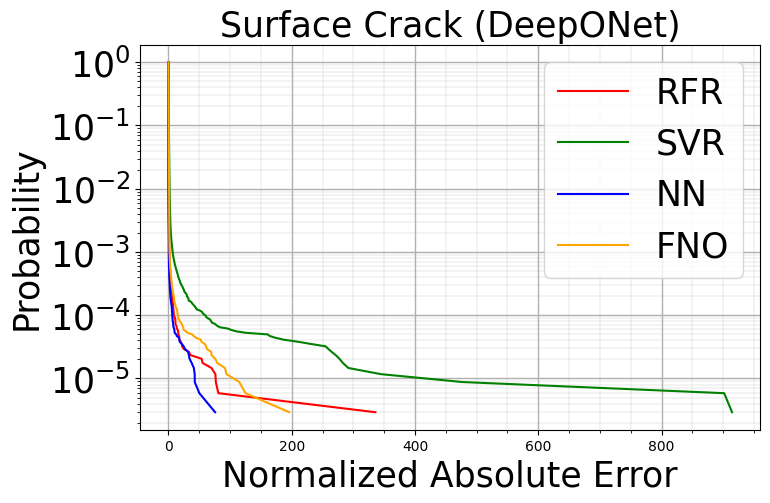

In [11]:
rfr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_rfr)
rfr_err_test = rfr_err_test.reshape(-1)

svr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_svr)
svr_err_test = svr_err_test.reshape(-1)

nn_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_nn)
nn_err_test = nn_err_test.reshape(-1)

fno_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_fno[:,::8].reshape(-1))
fno_err_test = fno_err_test.reshape(-1)

plt.rcParams["figure.figsize"] = (8,5)

x = np.sort(rfr_err_test) 
y = np.arange(len(rfr_err_test)) / float(len(rfr_err_test)) 
plt.plot(x,1-y, color='red', label="RFR")

x = np.sort(svr_err_test) 
y = np.arange(len(svr_err_test)) / float(len(svr_err_test)) 
plt.plot(x,1-y, color='green', label="SVR")

x = np.sort(nn_err_test) 
y = np.arange(len(nn_err_test)) / float(len(nn_err_test)) 
plt.plot(x,1-y, color='blue', label="NN")

x = np.sort(fno_err_test) 
y = np.arange(len(fno_err_test)) / float(len(fno_err_test)) 
plt.plot(x,1-y, color='orange', label="FNO")

plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.xlabel("Normalized Absolute Error", fontsize=25)
plt.ylabel("Probability", fontsize=25)
plt.semilogy()
# plt.xticks([0, 0.05, 0.1, 0.2], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.title("Surface Crack (DeepONet)", fontsize=25)
plt.show()

In [15]:
def display_numpy_array_as_table(arr):
    """
    Displays a 2D NumPy array as a formatted table.

    Args:
        arr (np.ndarray): The 2D NumPy array to display.
    """
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        print("Input must be a 2D NumPy array.")
        return

    # Determine the maximum width needed for each column
    # Convert all elements to strings first to handle different data types
    arr_str = np.array([[str(item) for item in row] for row in arr])
    col_widths = [max(len(item) for item in arr_str[:, col_idx]) for col_idx in range(arr_str.shape[1])]

    # Print the table header (optional, but good for clarity)
    # print(" | ".join(f"{'Col ' + str(i):<{col_widths[i]}}" for i in range(arr.shape[1])))
    # print("-+-".join("-" * width for width in col_widths)) # Separator line

    # Print the data rows
    for row in arr_str:
        print(" | ".join(f"{item:<{col_widths[i]}}" for i, item in enumerate(row)))


rfr_l2_test = np.load("../files/metrics/l2_err_rfr.npy")

svr_l2_test = np.load("../files/metrics/l2_err_svr.npy")

nn_l2_test = np.load("../files/metrics/l2_err_nn.npy")

fno_l2_test = np.load("../files/metrics/l2_err_fno.npy")

print("RFR")
display_numpy_array_as_table(np.expand_dims(rfr_l2_test[0], axis=0))
print("SVR")
display_numpy_array_as_table(np.expand_dims(svr_l2_test[0], axis=0))
print("NN")
display_numpy_array_as_table(np.expand_dims(nn_l2_test[0], axis=0))
print("FNO")
display_numpy_array_as_table(np.expand_dims(fno_l2_test[0], axis=0))

RFR
0.03375235708812186 | 0.032835056915870145 | 0.043110955148459536
SVR
0.31982003196240966 | 0.31754204134168956 | 0.3283491865708158
NN
0.034088782299323654 | 0.047883118863413475 | 0.03951384582548586
FNO
0.27906343895242885 | 0.25161267161277223 | 0.2859184563273222


# CORNER_CRACK_CS2_THROUGH_CS_THICKNESS

In [16]:
df = pd.read_csv("../files/data/FINAL_CSV/SINGLE/TEST/{}".format(csv_files[1]))
df = df.drop(columns=['b/t'])
df

,c_index,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,13.0,40.0,0.5,1.4,1.000,0.041134,7.970784,4.754799,0.672829
1,13.0,40.0,0.5,1.4,1.000,0.044196,7.952257,4.686180,0.671862
2,13.0,40.0,0.5,1.4,1.000,0.047259,7.934633,4.618272,0.670968
3,13.0,40.0,0.5,1.4,1.000,0.050321,7.917981,4.550931,0.670156
4,13.0,40.0,0.5,1.4,1.000,0.053383,7.902604,4.483863,0.669463
...,...,...,...,...,...,...,...,...,...
717435,24961.0,6.4,10.0,10.0,0.667,0.720029,10.175483,-5.079700,2.221446
717436,24961.0,6.4,10.0,10.0,0.667,0.725509,10.164997,-5.210541,2.218070
717437,24961.0,6.4,10.0,10.0,0.667,0.730989,10.155495,-5.342618,2.214248
717438,24961.0,6.4,10.0,10.0,0.667,0.736470,10.146219,-5.476238,2.210067


In [17]:
# Get unique combinations of the first four columns
test_combinations = df.iloc[:, 1:5].drop_duplicates().to_numpy()

print(len(test_combinations))

print("Different W/R values: ", np.unique(test_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(test_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(test_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(test_combinations[:,3], axis=0))

5605
Different W/R values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.3333  0.5     0.6667
  0.667   0.75    0.7502  0.8     0.9     0.9001  1.      1.1111  1.25
  1.333   1.3333  1.4993  1.5     2.      3.      3.003   5.9988  6.
 10.    ]
Different a/t values:  [ 0.6   0.7   0.8   0.9   0.95  1.1   1.25  1.4   1.8   2.4   3.2   4.5
  6.5  10.   15.  ]
Different r/t values:  [0.2   0.333 0.5   0.667 1.    1.5   2.    3.    5.   ]


## Preds

In [18]:
y_pred_t_rfr = np.load("../files/predictions/rfr/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_rfr = np.load("../files/predictions/rfr/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_rfr = np.load("../files/predictions/rfr/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_svr = np.load("../files/predictions/svr/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_svr = np.load("../files/predictions/svr/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_svr = np.load("../files/predictions/svr/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_nn = np.load("../files/predictions/nn/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_nn = np.load("../files/predictions/nn/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_nn = np.load("../files/predictions/nn/{}_BEARING.npy".format(csv_files[0][:-4]))

y_pred_t_fno = np.load("../files/predictions/fno/{}_TENSION.npy".format(csv_files[0][:-4]))
y_pred_b_fno = np.load("../files/predictions/fno/{}_BENDING.npy".format(csv_files[0][:-4]))
y_pred_p_fno = np.load("../files/predictions/fno/{}_BEARING.npy".format(csv_files[0][:-4]))

## Plots

In [19]:
def absolute_perctentage_error(y_true, y_pred):
    return np.abs((y_true -  y_pred) / y_true)

def perctentage_error(y_true, y_pred):
    return (y_true -  y_pred) / y_true

def mean_normalized_l2(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true -  y_pred, ord=2, axis=1) / np.linalg.norm(y_true, ord=2, axis=1))

In [20]:
d = df.to_numpy()[::8,1:]
d.shape

(89680, 8)

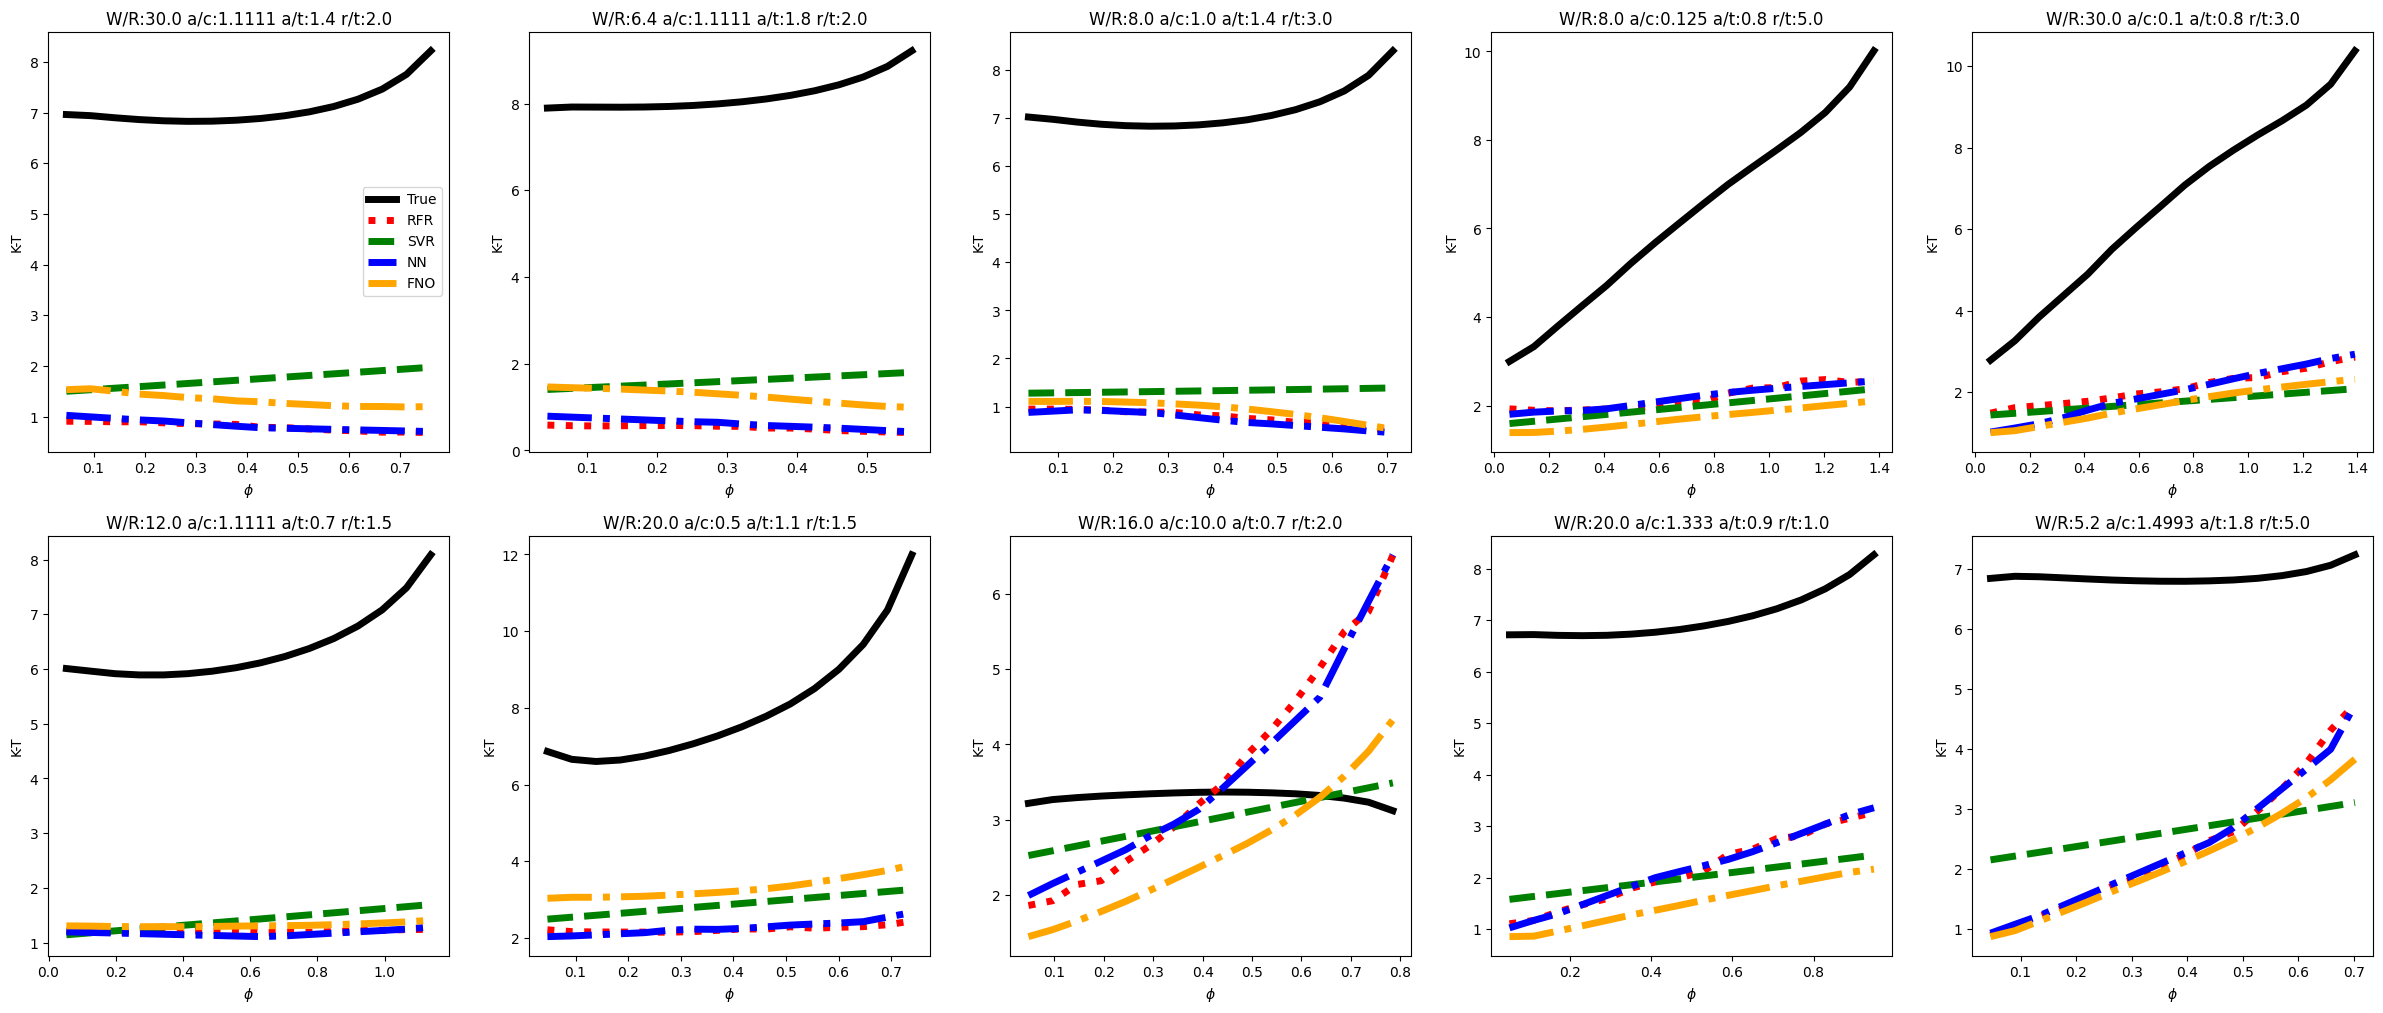

In [21]:

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_combinations))
        W_R = test_combinations[idx][0]
        a_c = test_combinations[idx][1]
        a_t = test_combinations[idx][2]
        r_t = test_combinations[idx][3]

        indices = np.where((d[:, 0] == W_R) & 
                    (d[:, 1] == a_c) &
                    (d[:, 2] == a_t) &
                    (d[:, 3] == r_t)) 
        indices = indices[0]

        phi_values = d[indices][:,4]

        axs[i,j].plot(d[indices][:,-4], d[indices][:,-3], color='black', label="True", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_rfr[idx*16:idx*16+16], label="RFR", color='red', linestyle=":", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_svr[idx*16:idx*16+16], label="SVR", color='green', linestyle="--", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_nn[idx*16:idx*16+16], label="NN", color='blue', linestyle="-.", linewidth=5)
        axs[i,j].plot(phi_values, y_pred_t_fno[idx,::8], label="FNO", color='orange', linestyle="dashdot", linewidth=5)
        

        axs[i,j].set_title("W/R:{} a/c:{} a/t:{} r/t:{}".format(W_R, a_c, a_t, r_t))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

In [22]:
rfr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_rfr)
rfr_err_test = rfr_err_test.reshape(-1)

svr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_svr)
svr_err_test = svr_err_test.reshape(-1)

nn_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_nn)
nn_err_test = nn_err_test.reshape(-1)

fno_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_fno[:,::8].reshape(-1))
fno_err_test = fno_err_test.reshape(-1)

plt.rcParams["figure.figsize"] = (8,5)

x = np.sort(rfr_err_test) 
y = np.arange(len(rfr_err_test)) / float(len(rfr_err_test)) 
plt.plot(x,1-y, color='red', label="RFR")

x = np.sort(svr_err_test) 
y = np.arange(len(svr_err_test)) / float(len(svr_err_test)) 
plt.plot(x,1-y, color='green', label="SVR")

x = np.sort(nn_err_test) 
y = np.arange(len(nn_err_test)) / float(len(nn_err_test)) 
plt.plot(x,1-y, color='blue', label="NN")

x = np.sort(fno_err_test) 
y = np.arange(len(fno_err_test)) / float(len(fno_err_test)) 
plt.plot(x,1-y, color='orange', label="FNO")

plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.xlabel("Normalized Absolute Error", fontsize=25)
plt.ylabel("Probability", fontsize=25)
plt.semilogy()
# plt.xticks([0, 0.05, 0.1, 0.2], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.title("Surface Crack (DeepONet)", fontsize=25)
plt.show()

ValueError: operands could not be broadcast together with shapes (89680,) (341440,) 

In [ ]:
def display_numpy_array_as_table(arr):
    """
    Displays a 2D NumPy array as a formatted table.

    Args:
        arr (np.ndarray): The 2D NumPy array to display.
    """
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        print("Input must be a 2D NumPy array.")
        return

    # Determine the maximum width needed for each column
    # Convert all elements to strings first to handle different data types
    arr_str = np.array([[str(item) for item in row] for row in arr])
    col_widths = [max(len(item) for item in arr_str[:, col_idx]) for col_idx in range(arr_str.shape[1])]

    # Print the table header (optional, but good for clarity)
    # print(" | ".join(f"{'Col ' + str(i):<{col_widths[i]}}" for i in range(arr.shape[1])))
    # print("-+-".join("-" * width for width in col_widths)) # Separator line

    # Print the data rows
    for row in arr_str:
        print(" | ".join(f"{item:<{col_widths[i]}}" for i, item in enumerate(row)))


rfr_l2_test = np.load("../files/metrics/l2_err_rfr.npy")

svr_l2_test = np.load("../files/metrics/l2_err_svr.npy")

nn_l2_test = np.load("../files/metrics/l2_err_nn.npy")

fno_l2_test = np.load("../files/metrics/l2_err_fno.npy")

print("RFR", end="")
display_numpy_array_as_table(np.expand_dims(rfr_l2_test[1], axis=0))
print("SVR", end="")
display_numpy_array_as_table(np.expand_dims(svr_l2_test[1], axis=0))
print("NN", end="")
display_numpy_array_as_table(np.expand_dims(nn_l2_test[1], axis=0))
print("FNO", end="")
display_numpy_array_as_table(np.expand_dims(fno_l2_test[1], axis=0))

RFR
0.12353802610269535 | 0.20928984300885597 | 0.23856922333343725
SVR
0.1874345289024565 | 0.5993631571134995 | 0.22450747673171376
NN
0.21870644904980005 | 0.5336553278788634 | 0.33167438258431153
FNO
0.12462306676819652 | 0.17716344158605954 | 0.15165577425104268
